In [1]:
import pandas as pd
data = pd.read_csv("carsdata_features.csv", engine='c')


In [2]:
import numpy as np
cat_var = data.select_dtypes(include=['int64'])
cont_var = data.select_dtypes(include=['float64'])


# Clustering

Les variables sont un mélange de variable catégorielles et variables continues. Les algorithmes de clustering tels que ** k-means ** reposent sur une définition de la distance (par exemple euclidienne) qui s'appliquent uniquement aux variables continues. Pour pouvoir inclure les variables catégorielles, on peut utiliser une variation de k-means qui s'appelle ** k-prototypes **.
Les étapes:
1. Imputer les valeurs NaN avec la moyenne de la colonne
2. Standardiser les variables continues
3. Définir une mesure de la qualité de clustering
4. Itérations de k-prototypes avec différents nombres de clusters pour optimiser la mesure de clustering.

## 1. Imputer les valeurs manquantes


In [3]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(np.array(cont_var))

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [4]:
cont_var_array = imp.transform(np.array(cont_var))


In [5]:
#avant imputation
np.array(cont_var)[:4,:1]

array([[ 86. ],
       [ 72.2],
       [ 89.9],
       [  nan]])

In [6]:
#apres imputation
cont_var_array[:4,:1]

array([[ 86.       ],
       [ 72.2      ],
       [ 89.9      ],
       [ 80.8939467]])

# 2. Standardiser les variables continues
Le champ de variation de chaques variables doit etre le meme pour que le poids relatif de chaque variable puisse etre equvalent dans la mesure de distance des échantillons. La standardisation consiste en une soustraction de la moyenne et une division par la standard deviation.

In [7]:
from sklearn import preprocessing
scaled_cont_var_array = preprocessing.scale(cont_var_array)
scaled_cont_var_array[:4,:2]

array([[ 0.98232348,  0.07834041],
       [-1.67257714, -1.75224355],
       [ 1.73262149,  2.06502068],
       [ 0.        ,  0.        ]])

# 3. Définir une mesure de qualité du clustering
Pour définir la qualité du clustering on utilisa le silhouette index:
\begin{equation*} \frac{b - a}{max(a,b)}\end{equation*} 

Avec a: la distance moyenne d'un point avec tous les autres point de la meme classe,
et b : la distance moyenne d'un point avec tous les points d'un autre cluster le plus proche.

Pour les variables catégorielles on ne peut pas utiliser la distance euclidienne. On utilise dans ce cas la distance de Hamming qui compte le nombre de diffrences sur toutes les variables catégorielles pour deux échantillons. Les valeurs a et b seront donc une combinaison de distance euclidienne et de Hamming avec un facteur gamma correspondant au ratio du nombres de variable dans les deux catégories.



### KMeans clustering:

In [8]:
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    kmeans_model = MiniBatchKMeans(n_clusters=3,init='k-means++').fit(cont_var_array[:10,:])


In [9]:
labels = kmeans_model.labels_
metrics.silhouette_score(cont_var_array[:10,:], labels)

0.58136795328011193

In [10]:
labels[:10]

array([2, 2, 2, 2, 0, 1, 2, 1, 2, 2])

Le score Silhouette proche de 1 indique que les clusters sont bien séparés.

### KModes clustering:

In [16]:
from kmodes import kmodes
kmodes_model = kmodes.KModes(n_clusters=3, init='Huang',n_init=5)
clusters = kmodes_model.fit_predict(np.array(cat_var)[:10,:])

In [17]:
clusters

array([0, 0, 0, 1, 2, 1, 2, 2, 0, 1], dtype=uint8)

In [18]:
metrics.silhouette_score(np.array(cat_var)[:10,:], clusters, metric='hamming')

0.088608344508605413

### KPrototypes clustering:

In [19]:
data = np.array(pd.DataFrame(cont_var_array).join(cat_var))

In [20]:
from kmodes import kprototypes
kproto = kprototypes.KPrototypes(n_clusters=3, init='Huang')

In [21]:
kproto_model = kproto.fit(data[:10,:], categorical=range(61,186))

In [22]:
clusters = kproto_model.predict(data[:10,:], categorical=range(61,186))

In [23]:
clusters

array([1, 1, 1, 1, 1, 2, 0, 2, 1, 1], dtype=uint8)

In [24]:
metrics.silhouette_score(data[:10,:], clusters)

0.56554027642991167

In [25]:
metrics.silhouette_score(data[:10,:], clusters, metric='euclidean')

0.56554027642991167

# 4. Définir le nombre de clusters par iterations
L'algorithme de clustering va etre utilisé de manière itérative avec un nombre de clusters différent pour identifier la valeur produisant le meilleur silhouette score.

### KPrototypes:

In [26]:
import random

def get_nb_clusters(nb_clusters, data=data,echantillons=100 ):
    nb_clusters = range(3,nb_clusters)
    scores = []
    sample_rows = random.sample(range(len(cont_var)), echantillons)

    for nc in nb_clusters:
        kproto = kprototypes.KPrototypes(n_clusters=nc, init='Huang',n_init=5)
        kproto_model = kproto.fit(data[sample_rows,:], categorical=range(61,186))
        clusters = kproto_model.predict(data[sample_rows,:], categorical=range(61,186))
        s = metrics.silhouette_score(data[sample_rows,:], clusters)
        scores.append(s)

        #print("Nombre de clusters: %d , score: %f" % (nc, s))
    return scores


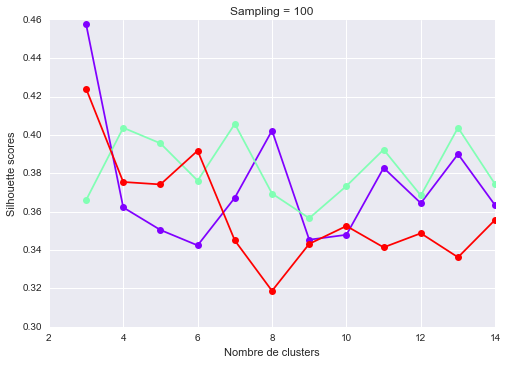

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import cm 

color=iter(cm.rainbow(np.linspace(0,1,3)))

for n in range(3):
    plt.plot(range(3,15), get_nb_clusters(15, echantillons=100), '-o', color=next(color))
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette scores')
plt.title('Sampling = 100')
plt.show()

### KMeans:

In [28]:
def get_nb_kmeans_clusters(nb_clusters, data=data,echantillons=100 ):
    nb_clusters = range(2,nb_clusters)
    scores = []
    sample_rows = random.sample(range(len(cont_var)), echantillons)

    for nc in nb_clusters:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            kmeans_model = MiniBatchKMeans(n_clusters=nc,init='k-means++').fit(data[sample_rows,:])
        s = metrics.silhouette_score(data[sample_rows,:], kmeans_model.labels_)
        scores.append(s)

        #print("Nombre de clusters: %d , score: %f" % (nc, s))
    return scores


In [29]:
from scipy.stats import mode
def plot_simulations(i, sampling):
    best_nb = []
    nb_clusters = range(2,15)
    color=iter(cm.rainbow(np.linspace(0,1,i)))
    for n in range(i):
        scores = get_nb_kmeans_clusters(15, data=scaled_cont_var_array, echantillons=sampling)
        plt.plot(nb_clusters, scores, '-o', color=next(color))
        best_nb.append(nb_clusters[scores.index(max(scores))])
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Silhouette scores')
    plt.title('KMeans clustering; Sampling = %d; optimal cluters: %d' % (sampling, mode(best_nb).mode[0]))
    plt.show()

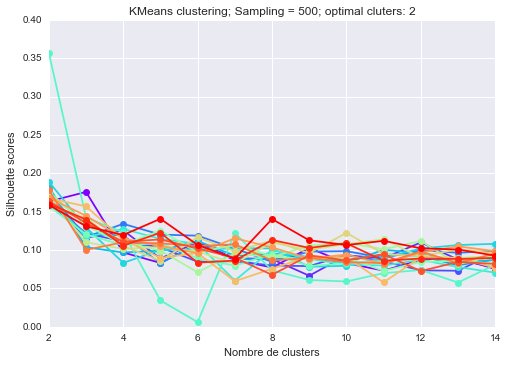

In [30]:
plot_simulations(20, 500)

Les différentes tentatives de clustering ont échouées. Les echantillons sont difficiles à séparer correctement car ont obtient que deux clusters qui est la valeur minimale. Ce qui veut dire que les différents modèles ne sont pas séparables par leur caractéristiques techniques.

# Analyse des variables

In [34]:
df = pd.DataFrame(cont_var_array)
df.columns = list(cont_var.columns.values)

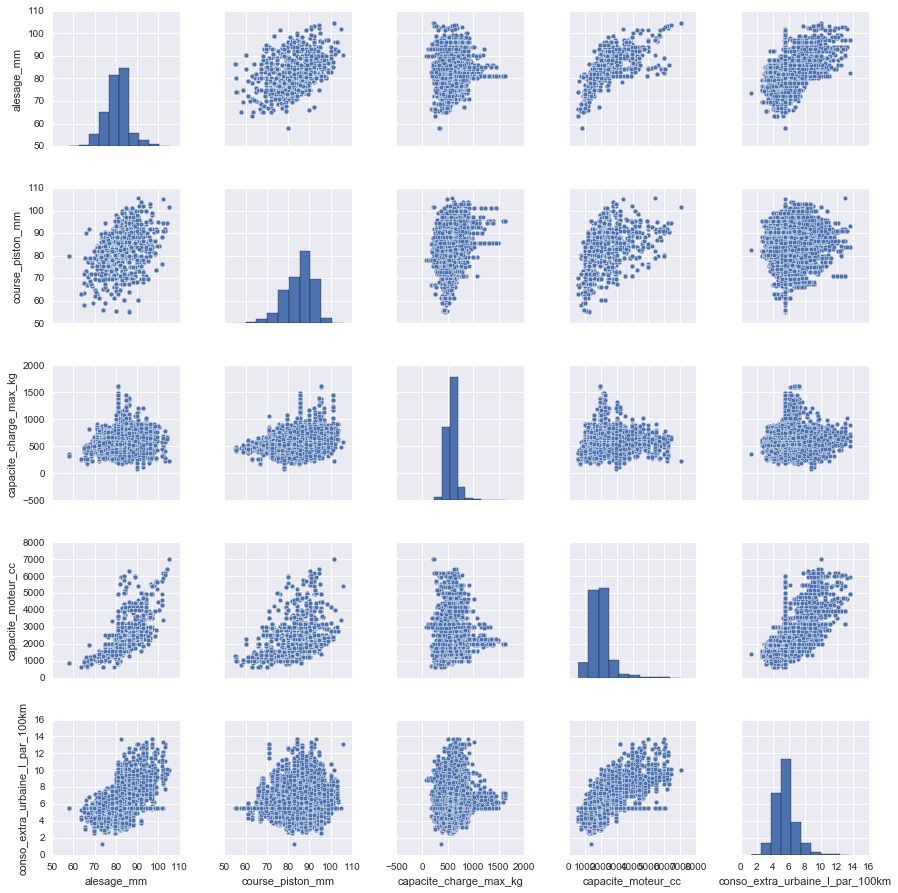

In [35]:
g = seaborn.pairplot(df.iloc[:,:5])

En se basant sur l'analyse de quelques variables il n'y a pas de séparations visibles entre les modèles.